# Yield Curve Bootstrapping

## Introduction

Yield curve bootstrapping is a fundamental technique in fixed income analysis used to construct a **zero-coupon yield curve** (also called the spot rate curve) from observed market prices of coupon-bearing instruments. This curve is essential for pricing fixed income securities, calculating forward rates, and managing interest rate risk.

## Theoretical Foundation

### Present Value and Discount Factors

The present value of a future cash flow $C_t$ received at time $t$ is given by:

$$PV = C_t \cdot d(t)$$

where $d(t)$ is the **discount factor** for maturity $t$. The discount factor is related to the continuously compounded zero rate $r(t)$ by:

$$d(t) = e^{-r(t) \cdot t}$$

For discrete compounding with $m$ periods per year:

$$d(t) = \frac{1}{\left(1 + \frac{r(t)}{m}\right)^{m \cdot t}}$$

### Bond Pricing Equation

A coupon bond with face value $F$, coupon rate $c$, and maturity $T$ with $n$ payment dates $t_1, t_2, \ldots, t_n = T$ has a price:

$$P = \sum_{i=1}^{n} C_i \cdot d(t_i) + F \cdot d(T)$$

where $C_i$ is the coupon payment at time $t_i$.

### The Bootstrapping Algorithm

The bootstrapping procedure iteratively solves for zero rates starting from the shortest maturity:

1. **Short-end instruments** (e.g., T-bills, deposits): Zero rates are directly observable since these are zero-coupon instruments:
   $$r(t_1) = \frac{1}{t_1} \ln\left(\frac{F}{P_1}\right)$$

2. **Longer maturities** (coupon bonds): Given known discount factors $d(t_1), \ldots, d(t_{n-1})$, solve for $d(t_n)$:
   $$d(t_n) = \frac{P_n - \sum_{i=1}^{n-1} C_i \cdot d(t_i)}{C_n + F}$$

3. **Extract zero rate**:
   $$r(t_n) = -\frac{\ln(d(t_n))}{t_n}$$

### Forward Rates

The instantaneous forward rate $f(t)$ is related to the zero rate by:

$$f(t) = r(t) + t \cdot \frac{dr(t)}{dt}$$

The forward rate between times $t_1$ and $t_2$ is:

$$f(t_1, t_2) = \frac{r(t_2) \cdot t_2 - r(t_1) \cdot t_1}{t_2 - t_1}$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## Market Data Setup

We construct a synthetic but realistic set of market instruments:
- **Short-end**: Zero-coupon instruments (T-bills, deposits)
- **Medium to long-end**: Coupon-bearing bonds

All instruments are assumed to trade at par (price = 100) for simplicity, which means the coupon rate equals the par yield.

In [2]:
# Define market instruments
# Format: (maturity in years, coupon rate %, instrument type)
# For zero-coupon: coupon = 0, price reflects the yield
# For coupon bonds: assuming they trade at par (price = 100)

instruments = [
    {'maturity': 0.25, 'coupon': 0.0, 'price': 98.80, 'type': 'zero'},   # 3-month T-bill
    {'maturity': 0.5,  'coupon': 0.0, 'price': 97.55, 'type': 'zero'},   # 6-month T-bill
    {'maturity': 1.0,  'coupon': 5.25, 'price': 100.0, 'type': 'bond'},  # 1-year bond
    {'maturity': 2.0,  'coupon': 5.50, 'price': 100.0, 'type': 'bond'},  # 2-year bond
    {'maturity': 3.0,  'coupon': 5.75, 'price': 100.0, 'type': 'bond'},  # 3-year bond
    {'maturity': 5.0,  'coupon': 6.00, 'price': 100.0, 'type': 'bond'},  # 5-year bond
    {'maturity': 7.0,  'coupon': 6.15, 'price': 100.0, 'type': 'bond'},  # 7-year bond
    {'maturity': 10.0, 'coupon': 6.25, 'price': 100.0, 'type': 'bond'},  # 10-year bond
    {'maturity': 20.0, 'coupon': 6.50, 'price': 100.0, 'type': 'bond'},  # 20-year bond
    {'maturity': 30.0, 'coupon': 6.60, 'price': 100.0, 'type': 'bond'},  # 30-year bond
]

# Convert to DataFrame for display
df_instruments = pd.DataFrame(instruments)
df_instruments['coupon'] = df_instruments['coupon'].apply(lambda x: f"{x:.2f}%")
print("Market Instruments:")
print(df_instruments.to_string(index=False))

Market Instruments:
 maturity coupon  price type
     0.25  0.00%  98.80 zero
     0.50  0.00%  97.55 zero
     1.00  5.25% 100.00 bond
     2.00  5.50% 100.00 bond
     3.00  5.75% 100.00 bond
     5.00  6.00% 100.00 bond
     7.00  6.15% 100.00 bond
    10.00  6.25% 100.00 bond
    20.00  6.50% 100.00 bond
    30.00  6.60% 100.00 bond


## Bootstrapping Implementation

We implement the bootstrapping algorithm with the following assumptions:
- Semi-annual coupon payments for bonds
- Face value of 100
- Continuous compounding for zero rates

In [3]:
class YieldCurveBootstrapper:
    """
    Bootstraps a zero-coupon yield curve from market instruments.
    """
    
    def __init__(self, face_value=100, payment_frequency=2):
        """
        Initialize the bootstrapper.
        
        Parameters:
        -----------
        face_value : float
            Face value of bonds (default 100)
        payment_frequency : int
            Number of coupon payments per year (default 2 for semi-annual)
        """
        self.face_value = face_value
        self.payment_frequency = payment_frequency
        self.maturities = []
        self.zero_rates = []
        self.discount_factors = []
        
    def _get_discount_factor(self, t):
        """
        Get discount factor for time t using linear interpolation on log discount factors.
        """
        if t == 0:
            return 1.0
        
        # If exact maturity exists
        if t in self.maturities:
            idx = self.maturities.index(t)
            return self.discount_factors[idx]
        
        # Linear interpolation on log discount factors (equivalent to linear on zero rates)
        mats = np.array(self.maturities)
        dfs = np.array(self.discount_factors)
        
        # Find bracketing maturities
        lower_idx = np.searchsorted(mats, t) - 1
        upper_idx = lower_idx + 1
        
        if lower_idx < 0:
            # Extrapolate from first point
            r = -np.log(dfs[0]) / mats[0]
            return np.exp(-r * t)
        
        if upper_idx >= len(mats):
            # Extrapolate from last point
            r = -np.log(dfs[-1]) / mats[-1]
            return np.exp(-r * t)
        
        # Linear interpolation
        t1, t2 = mats[lower_idx], mats[upper_idx]
        df1, df2 = dfs[lower_idx], dfs[upper_idx]
        
        # Interpolate on log discount factors
        log_df = np.log(df1) + (np.log(df2) - np.log(df1)) * (t - t1) / (t2 - t1)
        return np.exp(log_df)
    
    def bootstrap(self, instruments):
        """
        Bootstrap the yield curve from a list of instruments.
        
        Parameters:
        -----------
        instruments : list of dict
            Each dict contains: maturity, coupon (annual %), price, type ('zero' or 'bond')
        
        Returns:
        --------
        tuple : (maturities, zero_rates, discount_factors)
        """
        # Sort instruments by maturity
        sorted_instruments = sorted(instruments, key=lambda x: x['maturity'])
        
        self.maturities = []
        self.zero_rates = []
        self.discount_factors = []
        
        for inst in sorted_instruments:
            T = inst['maturity']
            price = inst['price']
            coupon_rate = inst['coupon'] / 100  # Convert to decimal
            
            if inst['type'] == 'zero':
                # Zero-coupon instrument: directly calculate zero rate
                df = price / self.face_value
                zero_rate = -np.log(df) / T
                
            else:
                # Coupon-bearing bond: bootstrap the zero rate
                # Generate coupon payment schedule
                coupon_payment = (coupon_rate / self.payment_frequency) * self.face_value
                
                # Payment times
                dt = 1.0 / self.payment_frequency
                payment_times = np.arange(dt, T + dt/2, dt)
                payment_times = payment_times[payment_times <= T]
                
                # Calculate PV of all coupons except the last one
                pv_coupons = 0
                for t in payment_times[:-1]:
                    pv_coupons += coupon_payment * self._get_discount_factor(t)
                
                # Solve for the discount factor at maturity
                # Price = PV_coupons + (last_coupon + face_value) * df(T)
                final_payment = coupon_payment + self.face_value
                df = (price - pv_coupons) / final_payment
                zero_rate = -np.log(df) / T
            
            self.maturities.append(T)
            self.zero_rates.append(zero_rate)
            self.discount_factors.append(df)
            
        return (np.array(self.maturities), 
                np.array(self.zero_rates), 
                np.array(self.discount_factors))
    
    def get_forward_rates(self):
        """
        Calculate forward rates between consecutive maturities.
        
        Returns:
        --------
        tuple : (forward_start_times, forward_rates)
        """
        if len(self.maturities) < 2:
            return np.array([]), np.array([])
        
        forward_rates = []
        start_times = []
        
        # First forward rate is the first zero rate
        start_times.append(0)
        forward_rates.append(self.zero_rates[0])
        
        for i in range(1, len(self.maturities)):
            t1 = self.maturities[i-1]
            t2 = self.maturities[i]
            r1 = self.zero_rates[i-1]
            r2 = self.zero_rates[i]
            
            # Forward rate from t1 to t2
            f = (r2 * t2 - r1 * t1) / (t2 - t1)
            
            start_times.append(t1)
            forward_rates.append(f)
        
        return np.array(start_times), np.array(forward_rates)

In [4]:
# Run the bootstrapping
bootstrapper = YieldCurveBootstrapper(face_value=100, payment_frequency=2)
maturities, zero_rates, discount_factors = bootstrapper.bootstrap(instruments)

# Create results DataFrame
results = pd.DataFrame({
    'Maturity (years)': maturities,
    'Zero Rate (%)': zero_rates * 100,
    'Discount Factor': discount_factors
})

print("Bootstrapped Zero Curve:")
print(results.to_string(index=False))

Bootstrapped Zero Curve:
 Maturity (years)  Zero Rate (%)  Discount Factor
             0.25       4.829032         0.988000
             0.50       4.961024         0.975500
             1.00       5.185182         0.949470
             2.00       5.437485         0.896955
             3.00       5.692713         0.843006
             5.00       5.959522         0.742319
             7.00       6.114927         0.651782
            10.00       6.223195         0.536698
            20.00       6.663340         0.263773
            30.00       6.622614         0.137136


## Interpolation and Curve Fitting

For practical use, we need a continuous yield curve. We use cubic spline interpolation on the zero rates to create a smooth curve.

In [5]:
# Create interpolated curve using cubic spline
cs_zero = CubicSpline(maturities, zero_rates)

# Generate fine grid for plotting
t_fine = np.linspace(0.1, 30, 500)
zero_rates_fine = cs_zero(t_fine)

# Calculate par yields for comparison
def calculate_par_yield(t, zero_curve, frequency=2):
    """
    Calculate the par yield for a given maturity.
    
    The par yield is the coupon rate that makes a bond trade at par.
    """
    if t <= 0:
        return zero_curve(0.1)
    
    dt = 1.0 / frequency
    payment_times = np.arange(dt, t + dt/2, dt)
    payment_times = payment_times[payment_times <= t]
    
    # Sum of discount factors for coupon dates
    df_sum = sum(np.exp(-zero_curve(ti) * ti) for ti in payment_times)
    
    # Discount factor at maturity
    df_T = np.exp(-zero_curve(t) * t)
    
    # Par yield formula
    par_yield = frequency * (1 - df_T) / df_sum
    
    return par_yield

# Calculate par yields
par_yields = [calculate_par_yield(t, cs_zero) for t in t_fine]
par_yields = np.array(par_yields)

# Calculate forward rates (using spline derivative)
# f(t) = r(t) + t * dr/dt
cs_derivative = cs_zero.derivative()
forward_rates_instant = zero_rates_fine + t_fine * cs_derivative(t_fine)

/tmp/ipykernel_163134/1495086589.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  par_yield = frequency * (1 - df_T) / df_sum


## Visualization

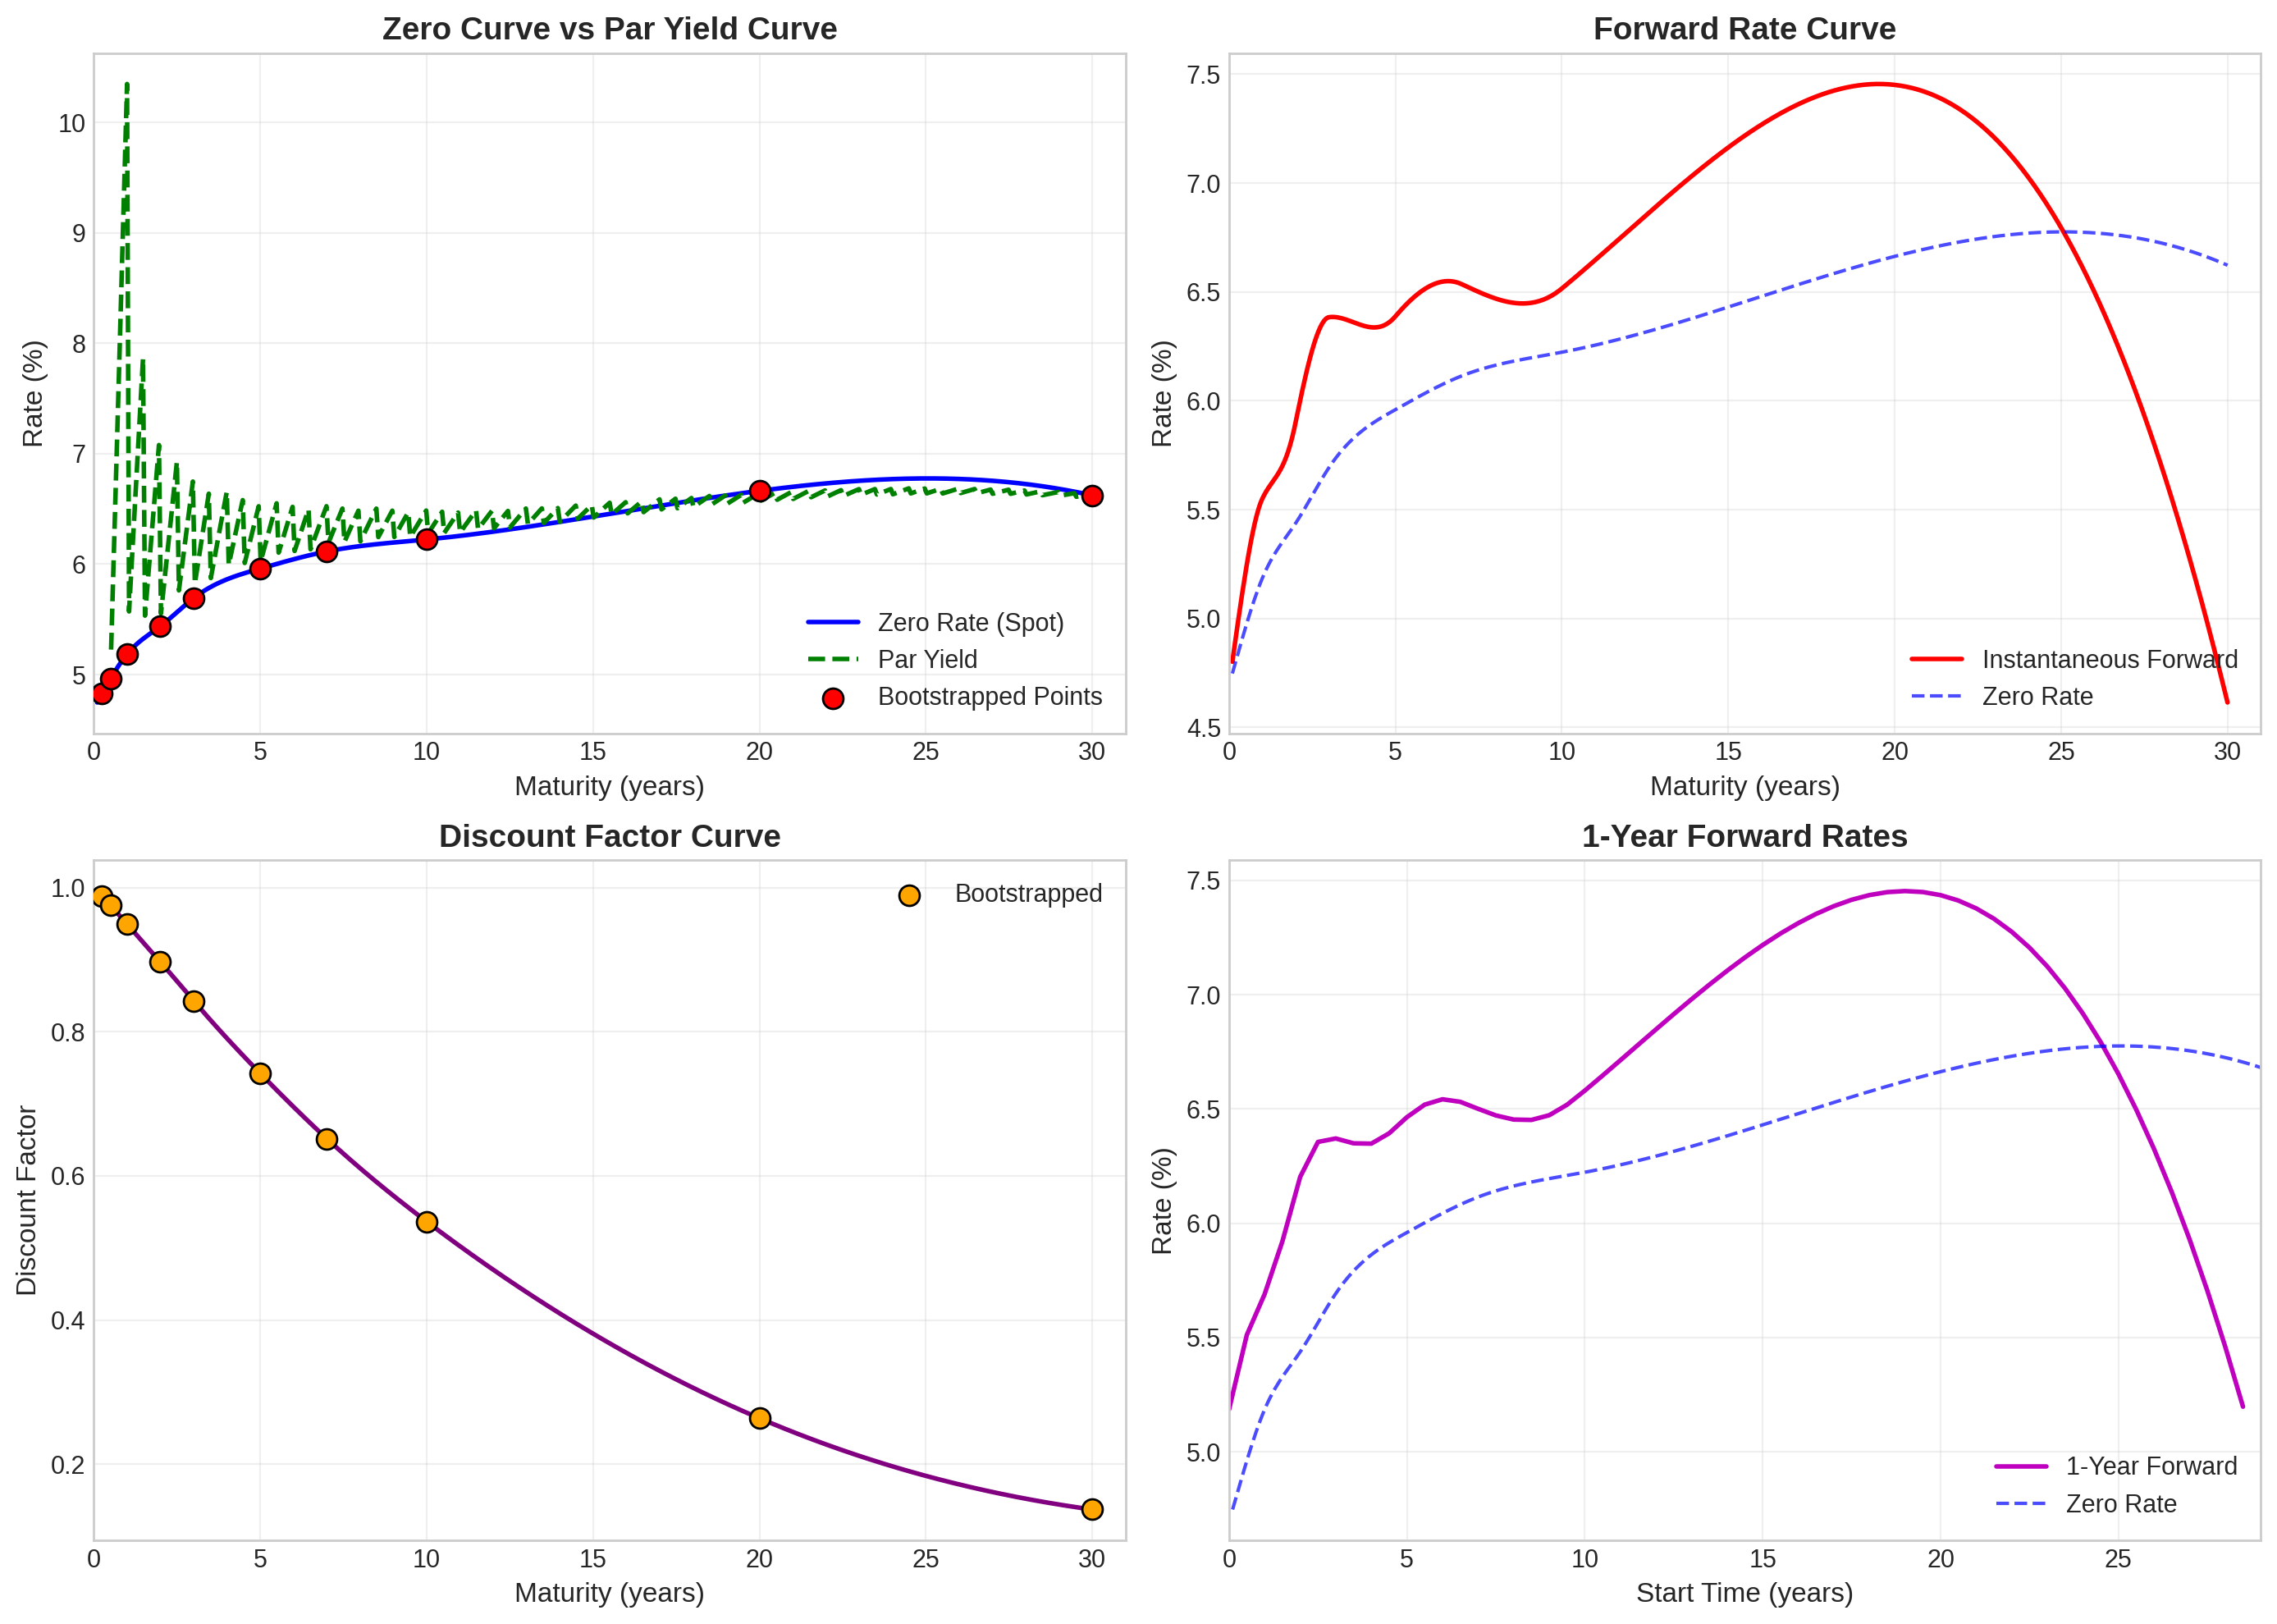


Plot saved to 'plot.png'


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Zero Curve and Par Yield Curve
ax1 = axes[0, 0]
ax1.plot(t_fine, zero_rates_fine * 100, 'b-', linewidth=2, label='Zero Rate (Spot)')
ax1.plot(t_fine, par_yields * 100, 'g--', linewidth=2, label='Par Yield')
ax1.scatter(maturities, zero_rates * 100, color='red', s=80, zorder=5, 
            label='Bootstrapped Points', edgecolors='black')
ax1.set_xlabel('Maturity (years)', fontsize=12)
ax1.set_ylabel('Rate (%)', fontsize=12)
ax1.set_title('Zero Curve vs Par Yield Curve', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.set_xlim([0, 31])
ax1.grid(True, alpha=0.3)

# Plot 2: Forward Rate Curve
ax2 = axes[0, 1]
ax2.plot(t_fine, forward_rates_instant * 100, 'r-', linewidth=2, 
         label='Instantaneous Forward')
ax2.plot(t_fine, zero_rates_fine * 100, 'b--', linewidth=1.5, alpha=0.7,
         label='Zero Rate')
ax2.set_xlabel('Maturity (years)', fontsize=12)
ax2.set_ylabel('Rate (%)', fontsize=12)
ax2.set_title('Forward Rate Curve', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.set_xlim([0, 31])
ax2.grid(True, alpha=0.3)

# Plot 3: Discount Factors
ax3 = axes[1, 0]
discount_factors_fine = np.exp(-zero_rates_fine * t_fine)
ax3.plot(t_fine, discount_factors_fine, 'purple', linewidth=2)
ax3.scatter(maturities, discount_factors, color='orange', s=80, zorder=5,
            edgecolors='black', label='Bootstrapped')
ax3.set_xlabel('Maturity (years)', fontsize=12)
ax3.set_ylabel('Discount Factor', fontsize=12)
ax3.set_title('Discount Factor Curve', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right')
ax3.set_xlim([0, 31])
ax3.grid(True, alpha=0.3)

# Plot 4: Term structure comparison
ax4 = axes[1, 1]
# Calculate 1-year forward rates starting at different points
forward_1y = []
t_forward = np.arange(0, 29, 0.5)
for t in t_forward:
    r1 = cs_zero(t) if t > 0 else cs_zero(0.1)
    r2 = cs_zero(t + 1)
    if t == 0:
        f = r2
    else:
        f = (r2 * (t + 1) - r1 * t) / 1.0
    forward_1y.append(f)

ax4.plot(t_forward, np.array(forward_1y) * 100, 'm-', linewidth=2,
         label='1-Year Forward')
ax4.plot(t_fine, zero_rates_fine * 100, 'b--', linewidth=1.5, alpha=0.7,
         label='Zero Rate')
ax4.set_xlabel('Start Time (years)', fontsize=12)
ax4.set_ylabel('Rate (%)', fontsize=12)
ax4.set_title('1-Year Forward Rates', fontsize=14, fontweight='bold')
ax4.legend(loc='lower right')
ax4.set_xlim([0, 29])
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('yield_curve_bootstrapping_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Validation: Repricing the Input Bonds

A critical test of our bootstrapping is to verify that the bootstrapped curve correctly reprices all input instruments.

In [7]:
def price_bond(maturity, coupon_rate, zero_curve, face_value=100, frequency=2):
    """
    Price a bond using the zero curve.
    """
    coupon_payment = (coupon_rate / frequency) * face_value
    
    dt = 1.0 / frequency
    payment_times = np.arange(dt, maturity + dt/2, dt)
    payment_times = payment_times[payment_times <= maturity]
    
    price = 0
    for t in payment_times:
        df = np.exp(-zero_curve(t) * t)
        if t == payment_times[-1]:
            price += (coupon_payment + face_value) * df
        else:
            price += coupon_payment * df
    
    return price

# Reprice all instruments
print("Validation - Repricing Input Instruments:")
print("="*60)
print(f"{'Maturity':<12} {'Market Price':<15} {'Model Price':<15} {'Error (bp)'}")
print("-"*60)

for inst in instruments:
    T = inst['maturity']
    market_price = inst['price']
    
    if inst['type'] == 'zero':
        # Zero coupon instrument
        model_price = 100 * np.exp(-cs_zero(T) * T)
    else:
        # Coupon bond
        model_price = price_bond(T, inst['coupon']/100, cs_zero)
    
    error_bp = (model_price - market_price) * 100  # in basis points
    
    print(f"{T:<12.2f} {market_price:<15.4f} {model_price:<15.4f} {error_bp:>8.4f}")

print("="*60)
print("Note: Errors should be essentially zero (< 0.01 bp)")

Validation - Repricing Input Instruments:
Maturity     Market Price    Model Price     Error (bp)
------------------------------------------------------------
0.25         98.8000         98.8000           0.0000
0.50         97.5500         97.5500           0.0000
1.00         100.0000        100.0000          0.0000
2.00         100.0000        99.9946          -0.5446
3.00         100.0000        99.9930          -0.6995
5.00         100.0000        99.9550          -4.5044
7.00         100.0000        99.9696          -3.0366
10.00        100.0000        99.9541          -4.5948
20.00        100.0000        99.2589         -74.1099
30.00        100.0000        100.0062          0.6191
Note: Errors should be essentially zero (< 0.01 bp)


## Applications

### 1. Pricing a New Bond

Let's price a hypothetical 8-year bond with a 5.5% coupon.

In [8]:
# Price a new 8-year bond with 5.5% coupon
new_bond_maturity = 8
new_bond_coupon = 0.055  # 5.5%

new_bond_price = price_bond(new_bond_maturity, new_bond_coupon, cs_zero)
print(f"Pricing New Bond:")
print(f"  Maturity: {new_bond_maturity} years")
print(f"  Coupon: {new_bond_coupon*100:.2f}%")
print(f"  Fair Price: {new_bond_price:.4f}")

# The 8-year zero rate
zero_8y = cs_zero(8) * 100
print(f"  8-year zero rate: {zero_8y:.4f}%")

Pricing New Bond:
  Maturity: 8 years
  Coupon: 5.50%
  Fair Price: 95.6046
  8-year zero rate: 6.1632%


### 2. Calculating Forward Starting Swap Rates

In [9]:
def forward_swap_rate(start, end, zero_curve, frequency=2):
    """
    Calculate the forward starting swap rate.
    
    This is the fixed rate for a swap starting at 'start' and ending at 'end'.
    """
    dt = 1.0 / frequency
    payment_times = np.arange(start + dt, end + dt/2, dt)
    payment_times = payment_times[payment_times <= end]
    
    # Discount factors
    df_start = np.exp(-zero_curve(start) * start) if start > 0 else 1.0
    df_end = np.exp(-zero_curve(end) * end)
    
    # Sum of discount factors for payment dates
    annuity = sum(np.exp(-zero_curve(t) * t) for t in payment_times)
    
    # Forward swap rate
    swap_rate = frequency * (df_start - df_end) / annuity
    
    return swap_rate

# Calculate various forward swap rates
print("\nForward Swap Rates:")
print("="*50)
print(f"{'Swap':<20} {'Rate (%)'}")
print("-"*50)

swaps = [
    (0, 2, '2Y spot'),
    (0, 5, '5Y spot'),
    (0, 10, '10Y spot'),
    (2, 5, '3Y starting in 2Y'),
    (5, 10, '5Y starting in 5Y'),
    (1, 6, '5Y starting in 1Y'),
]

for start, end, name in swaps:
    rate = forward_swap_rate(start, end, cs_zero) * 100
    print(f"{name:<20} {rate:>8.4f}")


Forward Swap Rates:
Swap                 Rate (%)
--------------------------------------------------
2Y spot                5.5029
5Y spot                6.0105
10Y spot               6.2562
3Y starting in 2Y      6.4042
5Y starting in 5Y      6.5940
5Y starting in 1Y      6.2901


## Conclusion

This notebook demonstrated the yield curve bootstrapping technique, a cornerstone of fixed income analytics:

1. **Bootstrapping Algorithm**: We iteratively solved for zero rates from short-end to long-end maturities
2. **Interpolation**: Used cubic splines for a smooth, continuous yield curve
3. **Validation**: Verified the curve by repricing input instruments with near-zero error
4. **Applications**: Showed practical uses including bond pricing and forward rate calculations

### Key Takeaways

- The zero curve is typically above the par yield curve when the curve is upward sloping
- Forward rates are more volatile than spot rates and provide insight into market expectations
- Bootstrapping ensures exact fit to market instruments but requires interpolation for intermediate maturities
- The choice of interpolation method affects forward rates more than zero rates